## Περιεχόμενα

- Εφαρμομή μεθόδου Embedded για επιλογή χαρακτηριστικών χρησιμοποιώντας Logistic Regression με διάφορες τιμές regularization c
- Εφαρμογή μεθόδου Wrapper (SequentialFeatureSelector), στα μοντέλα που χρησιμοποιούνται στο αρχείο 3.0.
- Εξαγωγή 2 υποσυνόλων χαρακτηριστικών βάσει των αποτελεσμάτων

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import (train_test_split, 
                                     StratifiedKFold)

from sklearn.feature_selection import SequentialFeatureSelector as SFS

from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)

from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_feature(i=0):
    '''
    Διάγραμμα Coefficient = f(Penalty) για δεδομένο χαρακτηριστικό i.
    
    Χρησιμοποιεί τη λίστα one_feature_vs_classes με len = n_features = 17,
    η οποία περιέχει dataframes με τους συντελεστές κάθε feature 
    με shape = (n_classes x n_penalties) = (7 x 7)
    
    axhline για την γραμμή που περνάει από το μηδέν, δηλαδή χαρακτηριστικό χωρίς να προσφέρει κάτι στην πρόβλεψη
    '''
    
    palette = sns.color_palette("bright", n_colors=17)
    
    ax = one_feature_vs_classes[i].T.plot(figsize=(9, 5), color=palette, legend=False)
    
    plt.xlabel('Penalty value')
    plt.ylabel('Coefficient')
    plt.axhline(y=0,
                xmin = one_feature_vs_classes[i].columns.min(),
                xmax = one_feature_vs_classes[i].columns.max(),
                color='black', linestyle='--', alpha=0.5)
    
    plt.title(feature_labels[i])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, one_feature_vs_classes[i].T.columns, title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [3]:
def plot_class(i=0):
    '''
    Διάγραμμα Coefficient = f(Penalty) για δεδομένο κλάση i.
    
    Χρησιμοποιεί τη λίστα one_feature_vs_classes με len = n_classes = 7,
    η οποία περιέχει dataframes με τους συντελεστές κάθε feature 
    με shape = (n_features x n_penalties) = (17 x 7)
    
    axhline για την γραμμή που περνάει από το μηδέν, δηλαδή χαρακτηριστικό χωρίς να προσφέρει κάτι στην πρόβλεψη
    '''  

    palette = sns.color_palette("bright", n_colors=17)
    
    ax = one_class_vs_features[i].T.plot(figsize=(9, 5), color=palette, legend=False)
    
    plt.xlabel('Penalty value')
    plt.ylabel('Coefficient')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    plt.title(class_labels[i])
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, one_class_vs_features[i].T.columns, title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [4]:
df = pd.read_csv("data_preprocessed.csv")

In [5]:
df.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Female,family_history_with_overweight_yes,FAVC_no,SMOKE_no,SCC_no,MTRANS_Public_Transportation,MTRANS_Walking,NObeyesdad
0,-0.522124,-0.875589,-0.862558,2.0,3.0,1,2.0,0.0,1.0,0,1,1,1,1,1,1,0,1
1,-0.522124,-1.947599,-1.168077,3.0,3.0,1,3.0,3.0,0.0,1,1,1,1,0,0,1,0,1
2,-0.206889,1.054029,-0.366090,2.0,3.0,1,2.0,2.0,1.0,2,0,1,1,1,1,1,0,1
3,0.423582,1.054029,0.015808,3.0,3.0,1,2.0,2.0,0.0,2,0,0,1,1,1,0,1,2
4,-0.364507,0.839627,0.122740,2.0,1.0,1,2.0,0.0,0.0,1,0,0,1,1,1,1,0,3


In [6]:
X = df.drop('NObeyesdad', axis=1)
y = df[['NObeyesdad']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                            y,
                            test_size=0.2,
                            random_state=42,
                            stratify = y
                           )

In [8]:
# stratify -> ίδιες αναλογίες
# training set

y_train.value_counts(normalize=True)

NObeyesdad
4             0.166469
6             0.153436
5             0.140403
2             0.137441
3             0.137441
1             0.135664
0             0.129147
Name: proportion, dtype: float64

In [9]:
# testing set

y_test.value_counts(normalize=True)

NObeyesdad
4             0.165485
6             0.153664
5             0.141844
1             0.137116
2             0.137116
3             0.137116
0             0.127660
Name: proportion, dtype: float64

##  Υπολογισμός της αξίας των χαρακτηριστικών με regularization
- Tο σφάλμα του Logistic Regression αποτελέτει απο δύο μέρη: Regularization Loss και το σφάλμα της πρόβλεψης
- Αυξάνοντας το penalty των coefficients, μειώνονται τελευταίοι οι συντελεστές που έχουν το σημαντικότερο ρόλο στη μείωση του σφάλματος της πρόβλεψης
- Επίσης μεγαλύτερη συντελεστές επισημαίνουν τη μεγαλύτερη επιρροή του χαρακτηριστικού ως προς το στόχο (απαιτείται κανονικοποίηση των αριθμητικών τιμών για να ισχύει)
    - (Hesterberg, T., Choi, N. H., Meier, L., & Fraley, C. (2008). Least angle and ℓ 1 penalized regression: A review.)

In [11]:
# Εκπαίδευση 7 μοντέλων με διαφορετικές τιμές penalty
# Αποθήκευση των τιμών των συντελεστών για κάθε 
# χαρακτηριστικό και κατηγορία και κάθε μοντέλο

coefs_df = []

# τιμές παραμέτρου C, αντιστροφο του penalty
penalties = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for c in penalties:   
    
    logit = LogisticRegression(C=c, penalty='l1', solver='saga', random_state=42, max_iter=5000) 
    logit.fit(X_train, y_train.squeeze())
    print(logit.score(X_test, y_test.squeeze()))
    
    # αποθήκευση των συντελεστών των χαρακτηριστικών στη λίστα 
    coefs_df.append(pd.Series(logit.coef_.ravel()))

0.16548463356973994
0.508274231678487
0.8794326241134752
0.9408983451536643
0.9574468085106383
0.9574468085106383
0.9550827423167849


In [12]:
# 7 coefficients, 1 για κάθε κλάση 
# 17 coefficients, 1 για κάθε χαρακτηριστικό 

logit.coef_.shape

(7, 17)

In [17]:
# 7 μοντέλα x (7 κλάσεις x 17 χαρακτηριστικά)
# --> 7 μοντέλα x 119

print(len(coefs_df))
print(coefs_df[0].shape)

7
(119,)


In [18]:
# κατηγορι΄ές του στόχου

class_labels = logit.classes_
class_labels

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [19]:
# ονόματα χαρακτηριστικών

feature_labels = X_train.columns
feature_labels

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Female', 'family_history_with_overweight_yes',
       'FAVC_no', 'SMOKE_no', 'SCC_no', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')

In [20]:
# Με σκοπό να κατανοήσουμε που αναφέρονται τα βάρη
# γίνεται αλλαγή των index, από αριθμητικά σε περιγραφικα

index = []
for class_ in class_labels: # logit.coef_ έχει shape 7x17, οπότε πρώτα loop στα class_labels
    for feature in feature_labels: # και μετά loop στα feature_labels
        index.append(f"{class_}_{feature}")

In [21]:
# μετατροπή της λίστας coefs_df σε dataframe
# με columns τα penalties και 
# με rows τα index που δημιουργήθηκαν πριν

coefs = pd.concat(coefs_df, axis=1)
coefs.columns = penalties
coefs.head()
coefs.index = index

In [22]:
# λογαριθμος του penalty για ευκολότερη σύγκριση, καθώς οι τιμές κυμαίνονται από 10^-3 έως 10^3
coefs.columns = np.log(penalties)
coefs.head()

,-6.907755,-4.605170,-2.302585,0.000000,2.302585,4.605170,6.907755
0_Age,0.0,0.000000,0.000000,-0.176242,-1.017776,-1.585211,-1.645749
0_Height,0.0,0.000000,2.501307,12.775695,21.944600,23.305152,23.430504
0_Weight,0.0,-1.521912,-11.653554,-49.650496,-78.597855,-85.070686,-85.840206
0_FCVC,0.0,0.000000,0.105937,0.604144,0.740344,0.669783,0.372935
0_NCP,0.0,0.000000,0.000000,0.146572,0.078635,0.093253,0.082890


In [23]:
print(np.log(0.001)) # μεγαλύτερο penalty
print(np.log(1000)) # μικρότερο penalty
# penalty = 1/c

-6.907755278982137
6.907755278982137


In [24]:
n_classes, n_features = logit.coef_.shape[0], logit.coef_.shape[1]

In [25]:
print(f"number of classes: {n_classes}\nnumber of features: {n_features}")

number of classes: 7
number of features: 17


In [26]:
# ομαδοποίηση κάθε feature
# κ΄άθε 17 θέσεις υπάρχει το ίδιο feature (κυκλικά) π.χ. coefs[1::17]

one_feature_vs_classes = []
for i in range(n_features):
    one_feature_vs_classes.append(coefs[i::n_features])

In [27]:
one_feature_vs_classes[2] # το βάρος δεδομένου χαρακτηριστικού (π.χ. `Weight`) για κάθε κατηγορία, σε κάθε τιμή penalty

,-6.907755,-4.605170,-2.302585,0.000000,2.302585,4.605170,6.907755
0_Weight,0.0,-1.521912,-11.653554,-49.650496,-78.597855,-85.070686,-85.840206
1_Weight,0.0,-0.571274,-5.265944,-28.539718,-48.376911,-52.905293,-53.451483
2_Weight,0.0,0.000000,-1.749716,-13.390223,-21.283827,-22.684826,-22.870861
3_Weight,0.0,0.000000,0.000000,0.000000,4.062513,5.359450,5.491020
4_Weight,0.0,0.000000,3.224406,14.055794,30.965803,35.383088,35.900802
5_Weight,0.0,1.121090,7.279232,27.523897,55.302492,62.533912,63.423628
6_Weight,0.0,1.413608,7.584613,26.477051,51.390880,56.672373,57.275166


In [28]:
# ομαδοποίηση κάθε κλάσης
# συνεχόμενες 17 θέσεις για ίδια κλάση π.χ. coefs[0:17]

one_class_vs_features = []
for i in range(n_features):
    one_class_vs_features.append(coefs[i*n_features:(n_features*(i+1))])

In [29]:
one_class_vs_features[6] # το βάρος κάθε χαρακτηριστικού για δεδομένη κλάση (π.χ. 6 ή `obesity III`), για κάθε τιμή penalty

,-6.907755,-4.605170,-2.302585,0.000000,2.302585,4.605170,6.907755
6_Age,0.0,0.000000,0.000000,0.000000,0.000000,0.646771,0.838280
6_Height,0.0,0.000000,-1.637710,-7.592952,-13.963229,-15.219813,-15.303132
6_Weight,0.0,1.413608,7.584613,26.477051,51.390880,56.672373,57.275166
6_FCVC,0.0,0.000000,0.547746,0.896265,2.384044,3.342318,3.421296
6_NCP,0.0,0.000000,0.000000,0.000000,0.000000,0.380878,0.439456
6_CAEC,0.0,0.000000,0.000000,-0.469209,-1.897589,-3.661399,-4.070776
6_CH2O,0.0,0.000000,0.000000,0.000000,0.013204,-0.019680,-0.139254
6_FAF,0.0,0.000000,-0.234919,-0.822993,-1.803239,-1.764169,-1.541253
6_TUE,0.0,0.000000,0.000000,0.000000,0.000000,0.445772,0.492849
6_CALC,0.0,0.000000,0.000000,0.000000,1.413783,2.367364,2.421606


### Στη συνέχεια θα δημιουργηθούν τα plots **Coefficient = f(Penalty)**

In [30]:
# Transpose για το διάγραμμα Coefficient = f(Penalty)
one_class_vs_features[0].T

,0_Age,0_Height,0_Weight,0_FCVC,0_NCP,0_CAEC,0_CH2O,0_FAF,0_TUE,0_CALC,0_Gender_Female,0_family_history_with_overweight_yes,0_FAVC_no,0_SMOKE_no,0_SCC_no,0_MTRANS_Public_Transportation,0_MTRANS_Walking
-6.907755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-4.605170,0.000000,0.000000,-1.521912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-2.302585,0.000000,2.501307,-11.653554,0.105937,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.000000,-0.176242,12.775695,-49.650496,0.604144,0.146572,0.296669,0.000000,0.000006,0.000000,0.000000,0.000000,-0.070813,0.000000,0.000000,0.000000,0.000000,0.000000
2.302585,-1.017776,21.944600,-78.597855,0.740344,0.078635,0.798527,0.000000,0.083250,-0.436213,0.000000,-1.103523,-0.644304,0.333045,-0.751341,0.000000,-1.801873,-0.605528
4.605170,-1.585211,23.305152,-85.070686,0.669783,0.093253,0.912757,0.002973,0.285797,-0.630193,-0.096929,-3.110849,-0.205143,1.064196,-1.539921,-0.442419,-2.491989,-1.600681
6.907755,-1.645749,23.430504,-85.840206,0.372935,0.082890,1.180730,0.040460,0.592035,-0.767277,-0.236238,-3.485764,-0.154362,1.284400,-1.671631,-0.798555,-2.773237,-1.741443


- Όσο αυξάνεται το c, μειώνεται το penalty ($CoefPenalty = 1/c$)
- Σε τιμές μικρού penalty υπάρχει μεγαλύτερη πιθανότητα το μοντέλο να κάνει overfit
- Σε μεγάλες τιμές penalty, οι τιμές των coefficients προσπαθούν να ελαχιστοποιήσουν το συνολικό σφάλμα το οποίο αποτελείται από το σφάλμα της πρόβλεψης και το σφάλμα του penalty
- Έτσι αν κάποιο χαρακτηριστικό δεν είναι χρήσιμο στην πρόβλεψη, μηδενίζεται πρώτο (`one_class_vs_features` και `plot_class`)

*Σημείωση*: Για τις embedded methods, είναι σημαντική η κανονικοποίηση των συνεχών τιμών, ώστε οι τιμές τους να είναι σε παρόμοιο εύρος με των κατηγορικών, και έτσι η διαφορά στα βάρη να αφορά στη διαφορά στη σημαντικότητα και όχι στην κλίμακα. 

## one_class_vs_features

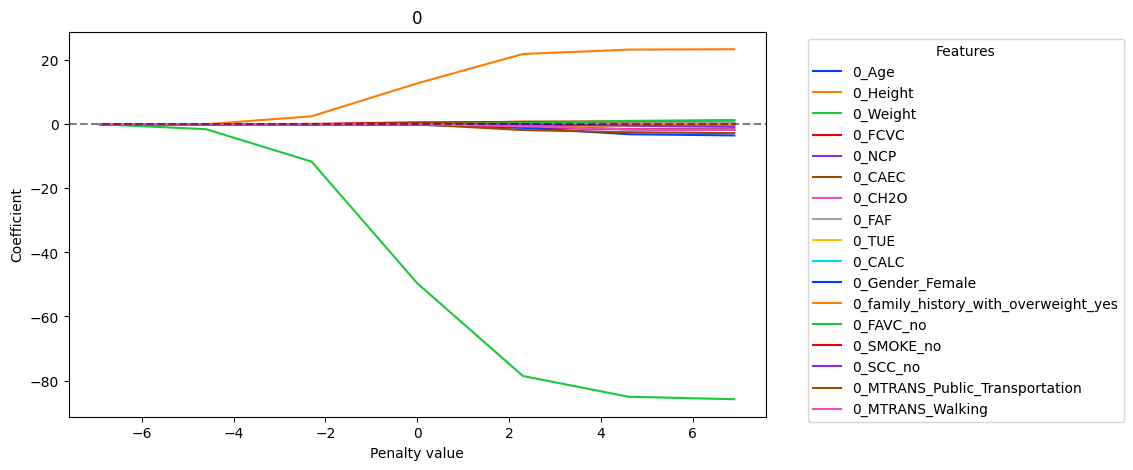

In [31]:
plot_class(0)

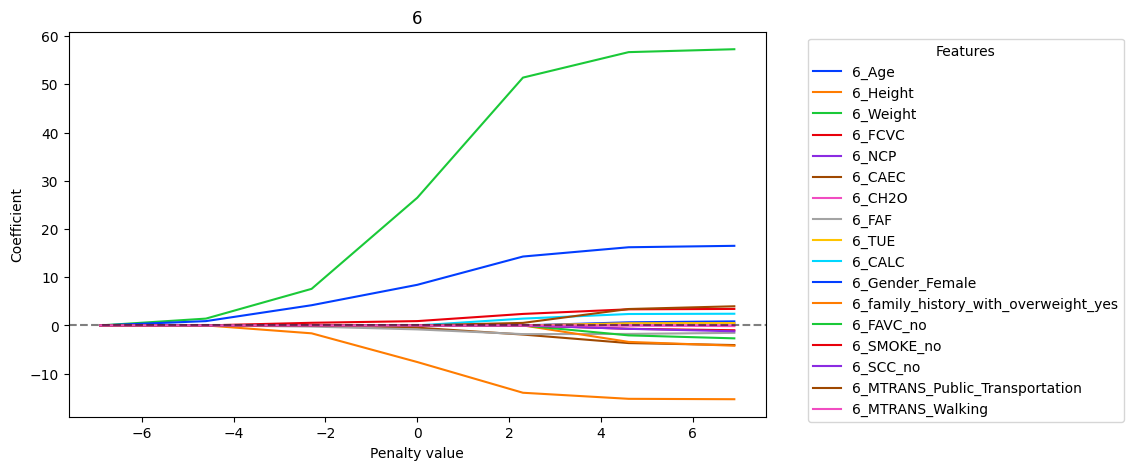

In [32]:
plot_class(6) # Height, Weight, Age

- Όπως φαινόταν κατά τα pairplot, το πιο σημαντικό χαρακτηριστικό είναι το βάρος και ακολουθεί το ύψος
- Αναφορικά με την κατηγορία 6, `obesity III` τα τρία καλύτερα χαρακτηριστικά συμφωνούν με αυτά που εξήχηθησαν ως πιο σημαντικά με τον υπολογισμό mutual information, συγκεκριμένα `Weight`, `Height`, `Age`
- Επίσης φαίνεται η μεγάλη αρνητική συνεισφορά του βάρους στην πρόβλεψη της κατηγορίας 0, ή `insufficient weight` (με την αύξηση του βάρους η πιθανότητα να είναι σε αυτή την κατηγορία μηδενίζεται), ενώ έχει αντίθετη επίδραση (θετική) στην κατηγορία 6, ή `obesity III`

## one_feature_vs_class

In [33]:
# λεξικό για ευκολότερη πρόσβαση σε επιθυμητή κατηγορία
feat_dict = {}
for i, col in enumerate(X_train.columns):
    feat_dict[col] = i

In [34]:
X_train.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CAEC', 'CH2O', 'FAF', 'TUE',
       'CALC', 'Gender_Female', 'family_history_with_overweight_yes',
       'FAVC_no', 'SMOKE_no', 'SCC_no', 'MTRANS_Public_Transportation',
       'MTRANS_Walking'],
      dtype='object')

- Το βάρος έχει τους μεγαλύτερους συντελεστές
- Όσο **μεγαλύτερος** ο βαθμός παχυσαρκίας για δεδομένο penalty, τόσο **μεγαλύτερη** και η τιμή του συντελεστή

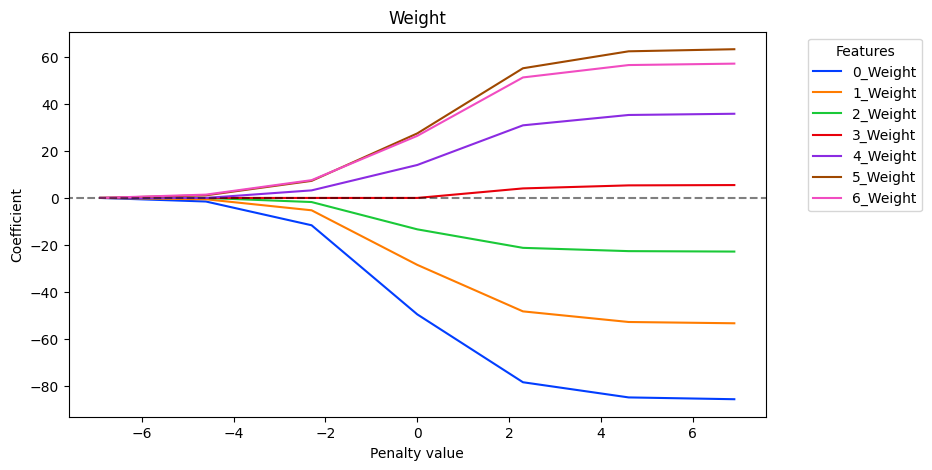

In [35]:
plot_feature(feat_dict["Weight"])

- Οι συντελεστές και του ύψους είναι επίσης σημαντικοί
- Όσο **μεγαλύτερος** ο βαθμός παχυσαρκίας για δεδομένο penalty, τόσο και **μικρότερη** η τιμή του συντελεστή του ύψους

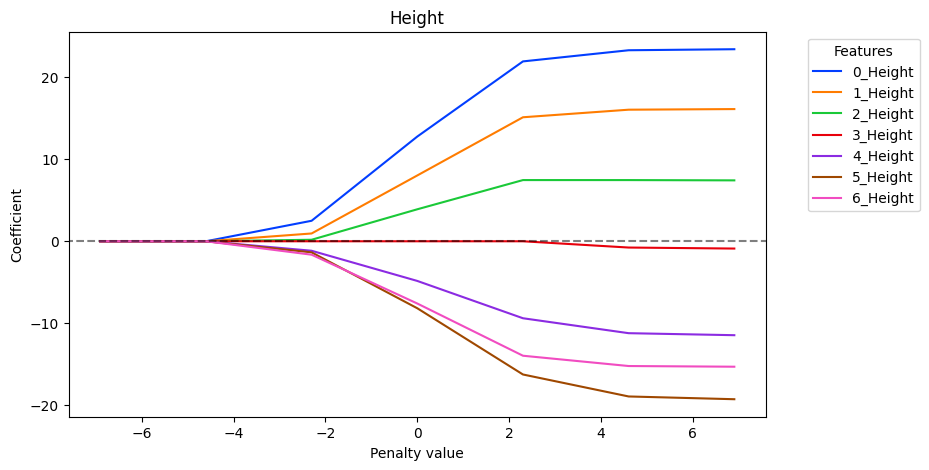

In [36]:
plot_feature(feat_dict["Height"])

- Η ηλικία εμφανίζει μικρότερους συντελεστές και δεν εμφανίζει τόσο εμφανές μοτίβο όσο τα προηγούμενα χαρακτηριστικά

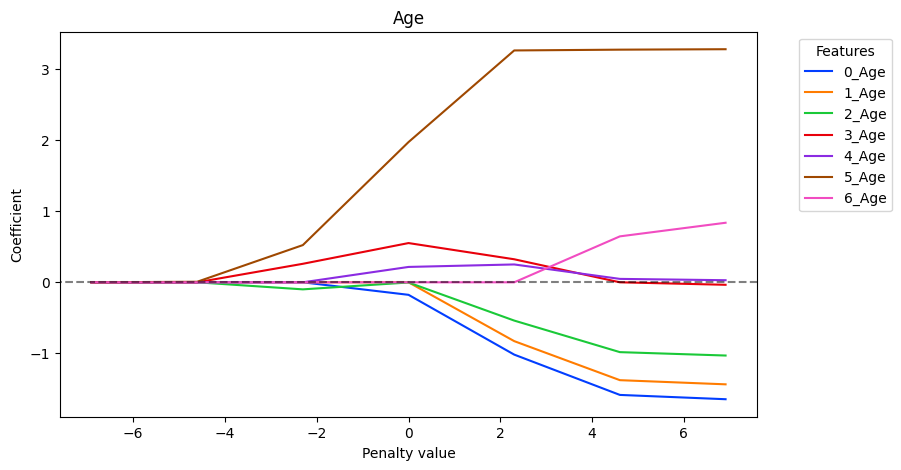

In [37]:
plot_feature(feat_dict["Age"])

- Η κατηγορία `obesity_type_III` έχει πολύ μεγάλο θετικό συντελεστή, και μηδενίζεται τελευταίος. Αυτό σημαίνει ότι οι περισσότεροι σε αυτή την κατηγορία είναι κατηγορίας `Female`.
- Αυτή η συμπεριφορά πιθανότατα να έχει προκύψει από την παραγωγή συνθετικών δεδομένων από πολύ λίγα πραγματικά δεδομένα για την κατηγορία `obesity_type_III` (ίσως να υπήρχε 1 δεδομένο της κατηγορίας `obesity_type_III`, το οποίο ήταν γυναίκα)
- Αντίθετη συμπεριφορά παρατηρείται στην κατηγορία `obesity_type_II`, όπου το 99.32% είναι άντρες.

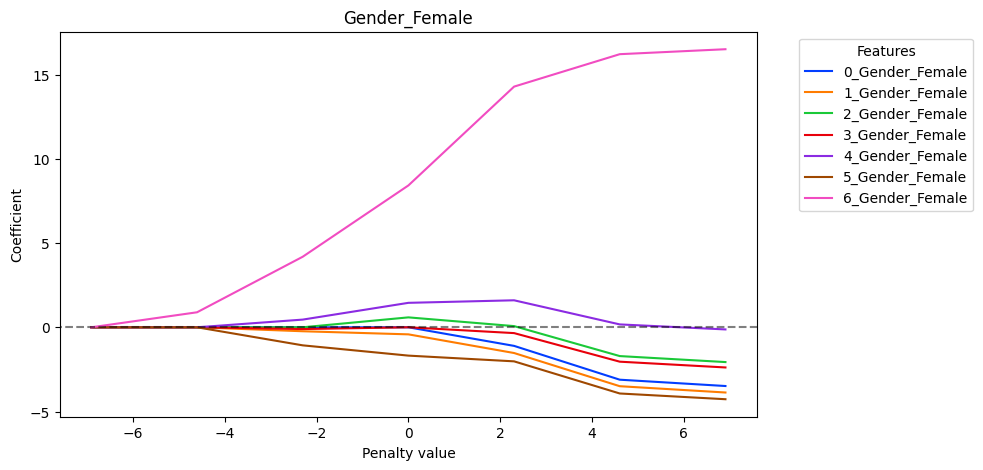

In [38]:
plot_feature(feat_dict["Gender_Female"])

In [39]:
grouped_data = df.groupby('Gender_Female')['NObeyesdad'].value_counts()
contingency_table = grouped_data.unstack(fill_value=0)
contingency_table

NObeyesdad,0,1,2,3,4,5,6
Gender_Female,,,,,,,
0,99,146,145,187,195,295,1
1,173,141,145,103,156,2,323


- Παράδειγμα μη σημαντικού χαρακτηριστικού
- Όμοιες κατηγορίες (`obesity ΙΙ` και `obesity ΙΙΙ`) παρουσιαζουν αντίθετο πρόσημο με τι πιο ακραίες τιμές του χαρακτηριστικού.

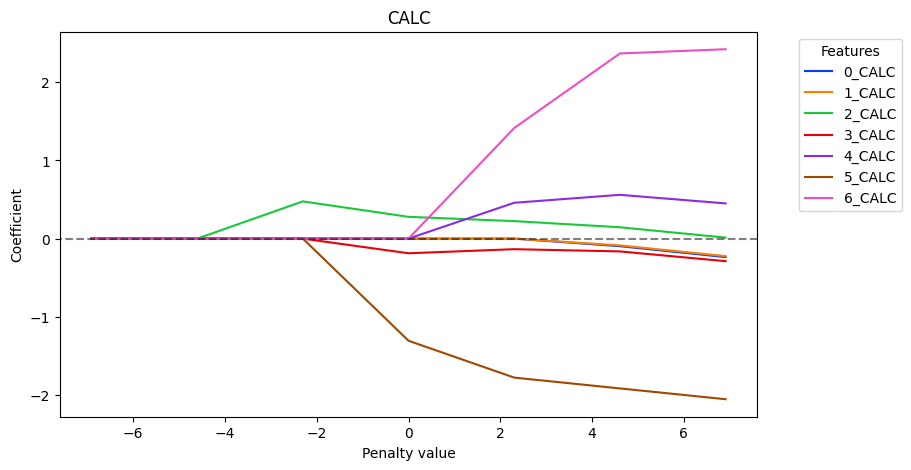

In [41]:
plot_feature(feat_dict["CALC"])

## Σημαντικότητα των Χαρακτηριστικών Βάση βελτίωσης της πρόβλεψης (Wrapper Methods)

In [42]:
X_train.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,Gender_Female,family_history_with_overweight_yes,FAVC_no,SMOKE_no,SCC_no,MTRANS_Public_Transportation,MTRANS_Walking
442,0.265964,0.196421,-0.824368,2.0,3.0,1,2.0,0.0,1.0,1,0,1,0,1,1,0,1
253,0.265964,-1.197192,-1.511786,2.0,1.0,1,2.0,0.0,2.0,1,1,1,0,1,1,1,0
554,-1.278980,-0.114387,-1.296801,2.0,2.0,1,3.0,1.0,0.0,1,0,0,0,1,1,1,0
1500,0.026548,-0.433096,0.158828,2.0,3.0,1,1.0,0.0,1.0,0,0,1,0,1,1,0,0
359,1.369288,-1.518795,-1.473596,2.0,3.0,1,2.0,1.0,0.0,1,1,1,1,1,1,1,0


### Random Forest Classifier

In [43]:
# stratified k fold για ίδια ποσοστά των κατηγοριών

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
# Αρχικοποίηση στιγμιότυπου της κλάσης SequentialFeatureSelector

sfs = SFS(
    estimator=RandomForestClassifier(random_state=42), # μοντέλο που θα χρησιμοποιηθεί
    tol=0.00001, # Ελάχιστη αύξηση του accuracy ώστε να προστεθεί το αμέσως καλύτερο χαρακτηριστικό
    direction='forward', # Αρχή από το ένα (το καλύτερο) χαρακτηριστικό, προς πολλά
    scoring='accuracy', # μετρική αξιολόγησης
    cv=stratified_kfold, # cross validation
    n_jobs=-1, # αριθμός επεξεργαστών για παραλληλισμό, -1 για την χρήση όλων των διαθέσιμων
)

In [40]:
sfs.fit(X_train, y_train.squeeze())

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=RandomForestClassifier(random_state=42),
                          n_jobs=-1, scoring='accuracy', tol=1e-05)

In [41]:
# το υποσύνολο των χαρακτηριστικών, το οποίο δε βελτιώθηκε περισσότερο από 0.001%,
# με κανένα από τα υπόλοιπα χαρακτηριστικά

sel_features = sfs.get_feature_names_out()
sel_features

array(['Height', 'Weight'], dtype=object)

In [42]:
rfc = RandomForestClassifier()
rfc.fit(X_train[sel_features], y_train.squeeze())

RandomForestClassifier()

In [43]:
print('Random Forest Classifier:')
print(f"training score: {rfc.score(X_train[sel_features], y_train.squeeze())}")
print(f"testing score: {rfc.score(X_test[sel_features], y_test.squeeze())}")

Random Forest Classifier:
training score: 1.0
testing score: 0.9716312056737588


- Τα δύο πιο σημαντικά Χαρακτηριστικά είναι το `Height` και `Weight`
- Όταν προστίθεται το τρίτο πιο σημαντικό χαρακτηριστικό για το συγκεκριμένο classifier (RandomForestClassifier) και συγκεκριμένους υπερπαραμέτρους, το σφάλμα δε βελτιώνεται περισσότερο από 0.001%
- Παρόλα αυτά φαίνεται να κάνει καλές προβλέψεις αν και παρατηρείται ένα ποσοστό overfitting

### AdaBoost Classifier

In [44]:
sfs = SFS(
    estimator=AdaBoostClassifier(algorithm='SAMME', random_state=42),
    tol=0.000000001,
    direction='forward',
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1,
)

In [45]:
sfs.fit(X_train, y_train.squeeze())

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=AdaBoostClassifier(algorithm='SAMME',
                                                       random_state=42),
                          n_jobs=-1, scoring='accuracy', tol=1e-09)

In [46]:
sel_features = sfs.get_feature_names_out()
sel_features

array(['Height', 'Weight'], dtype=object)

In [47]:
abc = AdaBoostClassifier(algorithm='SAMME')
abc.fit(X_train[sel_features], y_train.squeeze())

AdaBoostClassifier(algorithm='SAMME')

In [48]:
print(f"training score: {abc.score(X_train[sel_features], y_train.squeeze())}")
print(f"testing score: {abc.score(X_test[sel_features], y_test.squeeze())}")

training score: 0.43898104265402843
testing score: 0.41134751773049644


- ο AdaBoost Classifier δεν βελτιώνεται μετά τα τρία πρώτα χαρακτηριστικά (`Height`, `Weight`)
- Επίσης φαίνεται να αντιμετωπίζει πρόβλημα γενίκευσης (underfitting)

### GradientBoostingClassifier

In [49]:
sfs = SFS(
    estimator=GradientBoostingClassifier(random_state=42),
    tol=0.001,
    direction='forward',
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=-1,
)

In [50]:
sfs.fit(X_train, y_train.squeeze())

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                          estimator=GradientBoostingClassifier(random_state=42),
                          n_jobs=-1, scoring='accuracy', tol=0.001)

In [51]:
sel_features = sfs.get_feature_names_out()
sel_features

array(['Age', 'Height', 'Weight', 'NCP', 'Gender_Female'], dtype=object)

In [52]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train[sel_features], y_train.squeeze())

GradientBoostingClassifier()

In [53]:
print(f"training score: {gbc.score(X_train[sel_features], y_train.squeeze())}")
print(f"testing score: {gbc.score(X_test[sel_features], y_test.squeeze())}")

training score: 0.9994075829383886
testing score: 0.950354609929078


- Με όριο 0.1% αύξηση, ο Gradient Boosting Classifier, βελτιώνεται μέχρι να επιλεχθούν τα χαρακτηριστικά `Age`, `Height`, `Weight`, `NCP`, `Gender_Female`

- Από τη συγκεκριμένη μελέτη, θα κρατηθούν 2 υποσύνολα:
    - `Height`, `Weight`
    - `Height`, `Weight`, `Age`